<h1>HR Analytics</h1>

**Objective**: Explore the HR data set and create models to predict employee attrition 

**Data source**: https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
<br>Fictional HR data set created by IBM data scientists. Contains 1470 observations, with 35 features and feature of interest is 'Attrition'. 

**Methodology**: 
1. Data pre-processing
2. Conduct exploratory data analysis (EDA)
3. Build models, use them to predict and evaluate performance

******
<h2>Data Pre-processing</h2>

**Load libraries and data**

In [41]:
#Load libraries
library(readxl)
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(mlr)

#Read data 
data = read_excel('WA_Fn-UseC_-HR-Employee-Attrition.xlsx')

#set seed
set.seed(123)

**Examine data structure** 

In [42]:
str(data)
#summary(data) #don't want to clutter the output

Classes 'tbl_df', 'tbl' and 'data.frame':	1470 obs. of  35 variables:
 $ Age                     : num  41 49 37 33 27 32 59 30 38 36 ...
 $ Attrition               : chr  "Yes" "No" "Yes" "No" ...
 $ BusinessTravel          : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" "Travel_Frequently" ...
 $ DailyRate               : num  1102 279 1373 1392 591 ...
 $ Department              : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome        : num  1 8 2 3 2 2 3 24 23 27 ...
 $ Education               : num  2 1 2 4 1 2 3 1 3 3 ...
 $ EducationField          : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : num  1 2 4 5 7 8 10 11 12 13 ...
 $ EnvironmentSatisfaction : num  2 3 4 4 1 4 3 4 4 3 ...
 $ Gender                  : chr  "Female" "Male" "Male" "Female" ...
 $ HourlyRate              : num  94 61 92 56 40 

In [43]:
head(data)

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6


**Setup task**

In [44]:
#Convert character to factors, except 'Attrition'
data = data %>% mutate_if(is.character,as.factor) 
data$Attrition = as.character(data$Attrition)

#Convert data to data frame
data = as.data.frame(data)

#Remove redundant features 
data$Over18 = NULL
data$StandardHours = NULL
data$EmployeeCount = NULL

#Define task 
attr.task = makeClassifTask(data=data, target='Attrition')

********
<h2>Exploratory Data Analysis</h2>

Let's start off by looking what percentage of the staff left. Based on the data, it is around 16%.

In [45]:
print(round(sum(data$Attrition == 'Yes')/nrow(data),3))

[1] 0.161


Examine some of the features with regards to Attrition in detail

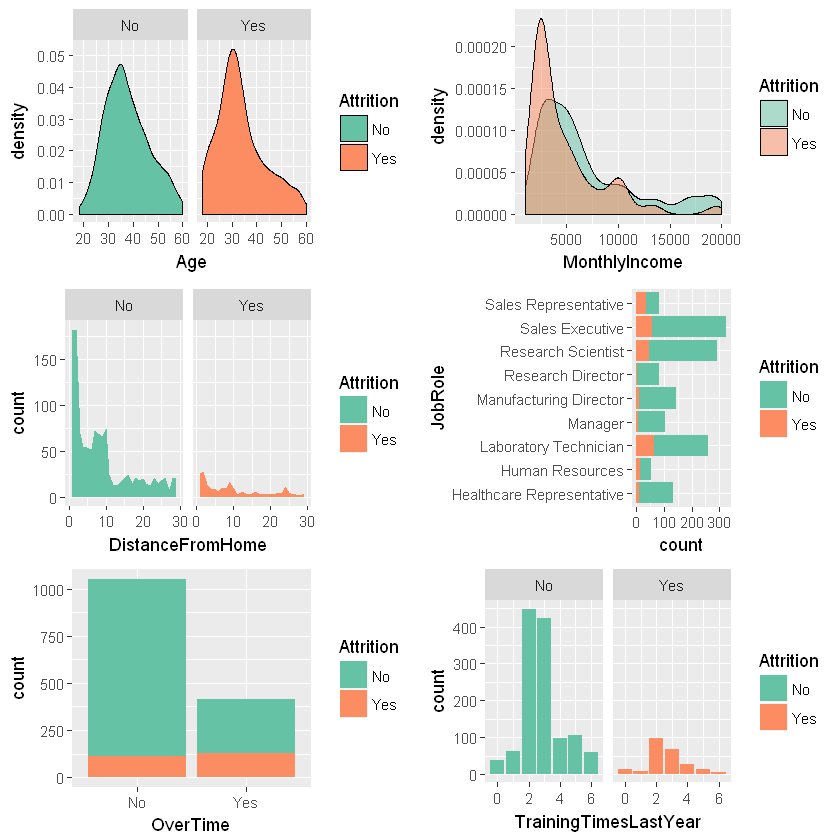

In [53]:

plot.Age = ggplot(data,aes(Age,fill=Attrition))+geom_density()+facet_grid(~Attrition) + scale_fill_brewer(palette="Set2")
plot.DistanceFromHome = ggplot(data,aes(DistanceFromHome,fill=Attrition)) + geom_area(stat='bin', binwidth=1) + facet_grid(~Attrition) + scale_fill_brewer(palette="Set2")
plot.JobRole = ggplot(data,aes(JobRole, fill=Attrition)) + geom_bar() + scale_fill_brewer(palette="Set2") + coord_flip()
plot.MonthlyIncome = ggplot(data,aes(MonthlyIncome,fill=Attrition)) +geom_density(alpha = 0.5) + scale_fill_brewer(palette="Set2")
plot.OverTime = ggplot(data,aes(OverTime,fill=Attrition))+geom_bar() + scale_fill_brewer(palette="Set2")
plot.TrainingTimesLastYear = ggplot(data,aes(TrainingTimesLastYear,fill = Attrition))+geom_bar() +facet_grid(~Attrition) + scale_fill_brewer(palette="Set2")


grid.arrange(plot.Age,plot.MonthlyIncome,
             plot.DistanceFromHome,plot.JobRole,
             plot.OverTime,plot.TrainingTimesLastYear, ncol=2)


********
<h2>Fit Models</h2>

**Choose Models**

In [54]:
## 3 models - Logistic Regression, Adaboost and Naive Bayes
## Logistic regression - regression model to model categorical variable, and in this case a binary outcome of either attrition or not
## Adaboost - Adaptive boosting, ensemble of weak learners, whereby each subsequent learner 'adapts' to the previously misclassified data 
## Naive Bayes - simple probablistic classifier by applying Bayes Theorem with strong independent assumptions about features

lrns = list(
  makeLearner("classif.logreg", id = "logreg"),
  makeLearner("classif.ada", id = "ada"), #adaboost
  makeLearner("classif.naiveBayes", id = "nb") #naive bayes
)


**Choose resampling strategy**

In [56]:
## Set the resampling strategy to 5 fold cross validation
## use to increase the number of observations for model fitting and evaluation, especially since attrition is a small % of the data

rdesc = makeResampleDesc('CV',iters= 5)

**Evaluate model performance**

Performance would be evaluated based on two metrics - accuracy and false negative rate. 

Accuracy is what % of the predictions are correct. The higher the accuracy, the better the performance.

False negative rate is how many of those who left were accurately predicted. This additional metric is used since failing to predict an attrition is (probably) worse than falsely detecting attrition. The lower the false negative rate, the better the performance.      

In [57]:
## Note that the fpr measure in mlr package defines false positive rate as the % of misclassifications in the positive class (i.e. false negative rate)
## Results verified using the confusion matrices
## The lower the fpr, the better the model at predicting those who actually left out of those who left

meas = list(acc,fpr)

bmr = benchmark(lrns, attr.task, rdesc, measures=meas)


Task: data, Learner: logreg
[Resample] cross-validation iter 1: acc.test.mean=0.871,fpr.test.mean=0.54
[Resample] cross-validation iter 2: acc.test.mean=0.888,fpr.test.mean= 0.5
[Resample] cross-validation iter 3: acc.test.mean=0.908,fpr.test.mean=0.548
[Resample] cross-validation iter 4: acc.test.mean=0.874,fpr.test.mean=0.628
[Resample] cross-validation iter 5: acc.test.mean=0.878,fpr.test.mean=0.538
[Resample] Aggr. Result: acc.test.mean=0.884,fpr.test.mean=0.551
Task: data, Learner: ada
[Resample] cross-validation iter 1: acc.test.mean=0.864,fpr.test.mean=0.76
[Resample] cross-validation iter 2: acc.test.mean=0.857,fpr.test.mean=0.72
[Resample] cross-validation iter 3: acc.test.mean=0.888,fpr.test.mean=0.714
[Resample] cross-validation iter 4: acc.test.mean=0.884,fpr.test.mean=0.698
[Resample] cross-validation iter 5: acc.test.mean=0.854,fpr.test.mean=0.827
[Resample] Aggr. Result: acc.test.mean=0.869,fpr.test.mean=0.744
Task: data, Learner: nb
[Resample] cross-validation iter 1: a

In [58]:
#Calculate confusion matrices 
calculateConfusionMatrix(getBMRPredictions(bmr)$data$logreg)
calculateConfusionMatrix(getBMRPredictions(bmr)$data$ada)
calculateConfusionMatrix(getBMRPredictions(bmr)$data$nb)

        predicted
true       No Yes -err.-
  No     1192  41     41
  Yes     130 107    130
  -err.-  130  41    171

        predicted
true       No Yes -err.-
  No     1218  15     15
  Yes     177  60    177
  -err.-  177  15    192

        predicted
true      No Yes -err.-
  No     993 240    240
  Yes     86 151     86
  -err.-  86 240    326

**Aggregated Performance**

In [59]:
getBMRAggrPerformances(bmr)

$data
$data$logreg
acc.test.mean fpr.test.mean 
    0.8836735     0.5507975 

$data$ada
acc.test.mean fpr.test.mean 
    0.8693878     0.7437766 

$data$nb
acc.test.mean fpr.test.mean 
    0.7782313     0.3629672

**Performance**

Based on the accuracy metric, logistic regression model was the best perfoming model with an accuracy of 88%, followed by adaboost model (87%) and lastly by naive bayes model (77%).

However, based on the false negative rate, naive bayes model was able to predict 63% of those who left correctly, followed by  logistic regression model (45%) and lastly by adaboost model (24%).

The trained model(s) could be used to predict existing staff propensity of attrition. Those with high propensity of quitting could be targeted for intervention policies.